### Imports

In [1]:
from dolfin import *

from fenics import *

from math import *

from mshr import *

import numpy as np


La forme du groupe de manchots est aléatoire. 

Le nombre de manchots M suit une loi de Poisson de paramètre lambda.
Les manchots sont serrés les uns aux autres pour minimiser les pertes de chaleur. On assimile leur placement à un quadrillage de forme hexagonale, où les manchots sont placés aux sommets. On suppose que tous les points à l'intérieur du groupe sont occupés. La frontière du groupe de manchots est uniquement déterminée par les manchots qui ont moins de six voisins. On suppose que tous les manchots du groupe ont au moins deux voisins.

On commence par générer un quadrillage avec cinq manchots respectant ces conditions. 
Les manchots suivants sont ajoutés sur le quadrillage en choisissant aléatoirement une position parmi les positions accessibles respectant les conditions énoncées précédemment. Ce tirage aléatoire suit une loi uniforme discrète.

Une fois le groupe formé, on suppose que le nombre de manchots présents dans le groupe reste constant. 

### Tirage du nombre de pingouins

In [2]:
poisson = 20
n = np.random.poisson(poisson)

### Placement des pingouins

In [3]:
b = sqrt(3)/2

centres = [0+0j, 1.5+b*1j, 0+2*b*1j, -1.5+b*1j, -1.5-b*1j, 0-2*b*1j, 1.5-b*1j]

premiers_pingouins = [0+0j, 1+0j,0.5+b*1j ,-0.5+b*1j,-1+0j, -0.5-b*1j, 0.5-b*1j]


Liste_pingouins_suivants = []
Liste_pingouins_exte = []
for i in range(1, len(centres)):
    depart = (i-2)
    Liste_pingouins_suivants.append(centres[i])
    for k in range(3):
        pingouin = premiers_pingouins[1:][(k+depart)%6]
        pingouin+=centres[i]
        Liste_pingouins_suivants.append(pingouin)
        Liste_pingouins_exte.append(pingouin)


def hexagone(n):
    if n <= 7: return 0
    return (n-8)//4+1

def pingouins_exte(n):
    n_hexagone = hexagone(n)
    return premiers_pingouins[n_hexagone+1:]+Liste_pingouins_exte[:n-7]

### Expression du vent

On tire la vitesse du vent et sa composante horizontale suivant une loi normale.

In [4]:
w0_moy =  60
w0_var = 0.5
alpha_moy = 5
alpha_var = 0.5

w0 = np.random.normal(w0_moy,w0_var)
alpha = np.random.normal(alpha_moy,alpha_var)

print(w0, alpha)

def W():
    return Expression(("w0*cos(alpha)","w0*sin(alpha)"))

59.32174797274645 4.787107062790449


In [5]:
print(W)

<function W at 0x7fade0cef7b8>


### Définition des paramètres

In [6]:
Pe= 12 
Tinf = -40
Tp = 39
R = sqrt(n)/2

wadim = W/w0



TypeError: unsupported operand type(s) for /: 'function' and 'float'

### Création du maillage

In [7]:
domain_vertices = [Point(pingouin.real, pingouin.imag) for pingouin in pingouins_exte(n)]
domain = Polygon(domain_vertices)
mesh = generate_mesh(domain,40)

In [8]:
Hh2 = FunctionSpace(mesh, 'P', 2)

### Conditions de bord

In [9]:
def liste_pingouins(n):
    return Liste_pingouins_finale[:n]

def test_dedans(n, xp, yp):
    L_triangles = []
    L_pingouins = liste_pingouins(n)
    for i in range(len(L_pingouins)):
        for j in range(i+1, len(L_pingouins)):
            for k in range(j+1, len(L_pingouins)):
                if abs(L_pingouins[i]-L_pingouins[j])< 1.2 and abs(L_pingouins[i]-L_pingouins[k])< 1.2 and abs(L_pingouins[k]-L_pingouins[j])< 1.2:
                    L_triangles.append((L_pingouins[i],L_pingouins[j],L_pingouins[k]))
    
    for triangle in L_triangles:
        x1, y1 = triangle[0].real, triangle[0].imag
        x2, y2 = triangle[1].real, triangle[1].imag
        x3, y3 = triangle[2].real, triangle[2].imag
        c1 = (x2 - x1) * (yp - y1) - (y2 - y1) * (xp - x1)
        c2 = (x3 - x2) * (yp - y2) - (y3 - y2) * (xp - x2)
        c3 = (x1 - x3) * (yp - y3) - (y1 - y3) * (xp - x3)
        if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
            return False

    return True

In [10]:
tol = 1E-14

class Frontiere(SubDomain):
    def inside(self, x, on_boundary):
        frontiere = on_boundary
        for i in range(len(Liste_pingouins_exte)-1):
            x_1, y_1 = Liste_pingouins_exte[i].real, Liste_pingouins_exte[i].imag
            x_2, y_2 = Liste_pingouins_exte[i+1].real, Liste_pingouins_exte[i+1].imag
            ymin = min([y_1, y_2])
            ymax = max([y_1, y_2])
            if x_1 != x_2:
                a = (y_2 - y_1)/(x_2 - x_1)
                b = y_2 - a*x_2
                frontiere = frontiere or (abs(x[1] - a*x[0]+b) < tol ) and  (x[1]<ymax and x[1]>ymin)
            if x_1 == x_2:            
                frontiere = frontiere or (( abs(x[0]-x_1)<tol) and (x[1]<ymax and x[1]>ymin))

        return frontiere
        

class Cadre_Top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (abs(x[0]-15)<tol) 
    
class Cadre_Bot(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (abs(x[0]+15)<tol) 

class Cadre_Right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (abs(x[1]-15)<tol) 
    
class Cadre_Left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (abs(x[0]+15)<tol) 

frontiere = Frontiere()  
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

cadre_top = Cadre_Top()
cadre_bot = Cadre_Bot()
cadre_right = Cadre_Right()
cadre_left = Cadre_Left()

ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

DirichCond = [DirichletBC(Hh2, Constant(1), frontiere), DirichletBC(Hh2, Constant(Tinf), cadre_top), DirichletBC(Hh2, Constant(Tinf), cadre_bot), DirichletBC(Hh2, Constant(Tinf), cadre_right), DirichletBC(Hh2, Constant(Tinf), cadre_left)]

### Résolution de la formulation variationnelle

In [11]:
u = TrialFunction(Hh2)
v = TestFunction(Hh2)
F = (inner(grad(u), grad(v))-Pe*(cos(alpha)*grad(u)[0]+sin(alpha)*grad(u)[1]*v))*dx


a = lhs(F)
l = rhs(F)

u = Function(Hh2)
solve(a == l, u, DirichCond)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Tracé de la solution

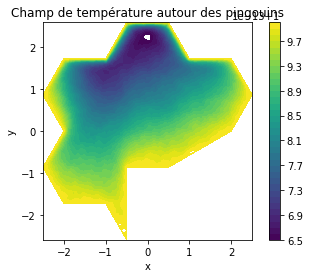

In [12]:
import matplotlib.pyplot as plt

plu = plot(u)
plt.title('Champ de température autour des pingouins')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(plu)